# Embedding-based Customer Segmentation


### imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
import numpy as np

from openai import OpenAI
from top_secret import my_sk
client = OpenAI(api_key=my_sk)

### load data

In [2]:
# load data
df = pd.read_csv("data/survey.csv")
print(df.shape)

(83, 2)


In [3]:
# drop rows with missing values
df = df.dropna()
print(df.shape)

(66, 2)


In [4]:
df.head()

,job_title,join_reason
0,Founder,"How to fine tune LLM effectively, and what LLM..."
1,Financial Management & Compliance Advisor,Gain knowledge and skills to be able to develo...
2,Founder in the making,Build an AI product
3,Staff Scientist,Better understanding and skill set in AI to ma...
4,Data scientist,Getting skills (for my resume)


### compute embeddings

In [5]:
# define number of embedding dimensions
job_embedding_dim = 12
reason_embedding_dim = 24

In [6]:
# compute embeddings for job descriptions
job_response = client.embeddings.create(
    input=df['job_title'],
    model="text-embedding-3-small",
    dimensions = job_embedding_dim
)

In [7]:
# compute embeddings for joined reasons
reason_response = client.embeddings.create(
    input=df['join_reason'],
    model="text-embedding-3-small",
    dimensions = reason_embedding_dim
)

In [8]:
# create list with all embeddings
embedding_list = [job_response.data[i].embedding + reason_response.data[i].embedding for i in range(len(df))]

In [9]:
# create df_embeddings
col_names = [f"job_embedding-{i+1}" for i in range(len(job_response.data[0].embedding))] + [f"reason_embedding-{i+1}" for i in range(len(reason_response.data[0].embedding))]
df_embeddings = pd.DataFrame(embedding_list, columns=col_names)

In [10]:
df_embeddings

,job_embedding-1,job_embedding-2,job_embedding-3,job_embedding-4,job_embedding-5,job_embedding-6,job_embedding-7,job_embedding-8,job_embedding-9,job_embedding-10,...,reason_embedding-15,reason_embedding-16,reason_embedding-17,reason_embedding-18,reason_embedding-19,reason_embedding-20,reason_embedding-21,reason_embedding-22,reason_embedding-23,reason_embedding-24
0,0.201901,-0.247121,0.197661,0.393203,-0.035770,-0.209320,0.054715,0.251537,-0.436657,0.164541,...,0.066032,-0.161158,0.024040,-0.063145,0.047318,0.582741,0.059386,0.093600,0.000151,0.013845
1,-0.347484,0.215109,0.563136,-0.004768,-0.034416,0.384376,0.116032,0.099349,0.376509,0.258104,...,0.246304,0.045254,-0.044179,0.172198,0.263729,0.142512,0.260717,-0.003788,0.088842,0.225438
2,0.092370,-0.127117,0.152763,0.506253,-0.135587,-0.181890,0.157432,0.561026,-0.324838,-0.000301,...,-0.143942,-0.119419,-0.047002,-0.076387,-0.163954,-0.108238,0.072441,0.249925,0.033871,-0.014810
3,-0.152119,0.170016,0.254981,-0.159193,-0.387244,-0.041076,0.193963,0.135075,-0.148966,-0.738354,...,0.263452,0.303230,-0.244194,0.262978,0.262978,0.015588,-0.000213,0.020856,0.289813,-0.035911
4,-0.034204,-0.247500,0.222400,-0.422170,0.099422,-0.365798,-0.131980,0.402213,-0.285561,-0.310044,...,0.524617,0.271133,-0.278352,0.088840,0.022624,0.136870,0.312845,0.011964,-0.056102,0.008460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,-0.244475,0.416019,0.344223,-0.351034,-0.350182,-0.181334,0.198929,0.282927,-0.261502,-0.105069,...,0.240018,0.195398,-0.127632,0.009929,0.080781,0.025145,0.051452,0.045038,0.214176,0.406413
62,-0.550306,0.088296,0.301594,0.028080,-0.470340,-0.086899,-0.118337,0.417889,0.188093,-0.202925,...,0.005529,0.115296,-0.192243,0.193757,0.257165,0.101336,0.040072,0.028382,0.097215,0.281553
63,-0.141610,-0.323546,0.431291,-0.283687,0.103385,-0.106889,0.236821,0.167067,-0.285400,-0.207238,...,-0.035030,0.146471,-0.149150,-0.058201,0.120173,0.055522,0.311200,0.217721,0.157883,0.232606
64,-0.226732,0.269441,0.187619,-0.367147,-0.252057,-0.490028,0.280230,0.350662,-0.268542,-0.118086,...,0.342599,0.066214,0.010581,-0.178791,0.083069,0.017105,0.578656,-0.124271,0.213583,-0.071125


### Clustering

In [11]:
# KMeans
num_segments = 5
clustering = KMeans(n_clusters=num_segments, random_state=0).fit(df_embeddings)

# add segments to survey data
df["segment"] = clustering.labels_+1

In [12]:
# # DBSCAN (more advanced, no need to set number of segments)
# clustering = DBSCAN(eps=1.05, min_samples=2).fit(df_embeddings)

# # add segments to survey data
# df["segment"] = clustering.labels_+1

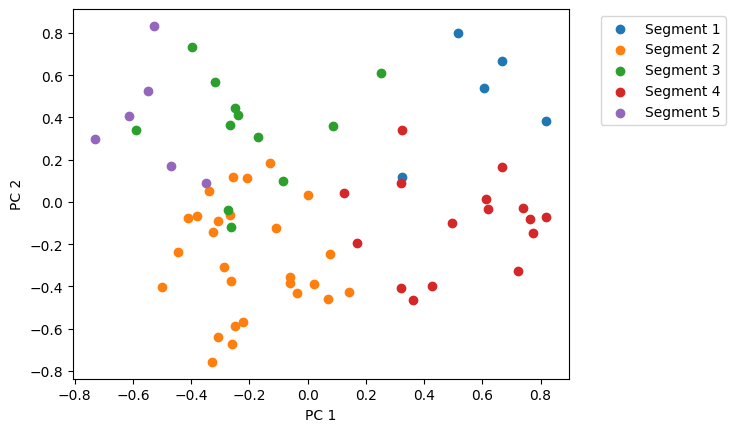

In [13]:
# use PCA to reduce dimensionality for visualization
X = PCA(n_components=2).fit_transform(df_embeddings)

# plot components for each segment
for label in range(num_segments):
    indexes = np.where(clustering.labels_ == label)[0]
    plt.scatter(X[indexes,0], X[indexes,1], label=f"Segment {label+1}")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.show()

### Generate Segment Profiles with GPT

In [14]:
def dataframe_to_markdown(df):
    """
    Converts a Pandas DataFrame into a Markdown table.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to be converted into a Markdown table.

    Returns
    -------
    str
        A string representing the DataFrame in Markdown table format.
        The table includes a header row with column names and rows
        formatted with proper Markdown table syntax."""
    
    # Create the header row
    markdown = f"| {' | '.join(df.columns)} |\n"
    markdown += f"| {' | '.join(['-' * len(col) for col in df.columns])} |\n"
    
    # Add each row
    for _, row in df.iterrows():
        markdown += f"| {' | '.join(str(cell) for cell in row)} |\n"
    
    return markdown

In [15]:
prompt_template = lambda markdown_table: f"""You are a business strategist specializing in customer segmentation and profiling. \
Below is a table of survey responses from customers, including their job titles and reasons for joining an AI bootcamp. \
Your task is to analyze the responses and generate a **single predominant customer profile** that represents the most common \
characteristics and motivations across the group.

Please include:
1. **Job Title**: A single representative job title summarizing those listed in the table
2. **Desired Outcomes**: A single representative desired outcome synthesizing those listed in the table
3. **Key Challenges**: A single representative key challenge synthesizing those listed in the table

### Survey Responses

{markdown_table}                                                                                                                                       |

### Instructions:
- Keep each section concise (1 sentence or bullet points).
- Use simple language and avoid unnecessary details.
- Total response should be under **100 words**.
- Only include the three items list above (i.e. Job Title, Desired Outcomes, and Key Challenges)

Begin your analysis and generate the customer profile below:
"""

In [16]:
def generate_avatar(my_sk, df_segment):
    """
    Generates a customer avatar by using a GPT model to process a Pandas DataFrame segment.

    Parameters
    ----------
    my_sk : str
        The API key or secret used for authenticating the GPT API client.
    df_segment : pandas.DataFrame
        A segment of a Pandas DataFrame containing relevant customer data 
        that will be used to construct the prompt.

    Returns
    -------
    str
        A string representing the generated customer avatar."""
    
    # construct prompt
    markdown_table = dataframe_to_markdown(df_segment)
    prompt = prompt_template(markdown_table)
    
    # make api call
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "user", "content": prompt}
        ], 
        temperature = 0.5
    )
    
    # extract response
    customer_avatar = response.choices[0].message.content
    return customer_avatar

In [17]:
for i in range(num_segments):
    survey_data = df[clustering.labels_==i][['job_title', 'join_reason']]
    print("Segment", i+1, "| Size:", len(survey_data))
    print(generate_avatar(my_sk, survey_data))
    print("-" * 100)

Segment 1 | Size: 5
- **Job Title**: Founder  
- **Desired Outcomes**: Acquire practical skills to build and fine-tune AI applications independently.  
- **Key Challenges**: Limited time and resources to fully engage with coding examples and implement AI projects effectively.  
----------------------------------------------------------------------------------------------------
Segment 2 | Size: 27
- **Job Title**: Data Scientist  
- **Desired Outcomes**: Gain practical skills and knowledge in AI to enhance career opportunities and effectively contribute to AI projects.  
- **Key Challenges**: Bridging knowledge gaps in AI concepts and practical applications to confidently integrate AI into their current roles or transition to AI-focused careers.
----------------------------------------------------------------------------------------------------
Segment 3 | Size: 12
- **Job Title**: Product Manager  
- **Desired Outcomes**: Gain practical experience and knowledge in AI and LLMs to effec

In [18]:
df[df["segment"]==5]

,job_title,join_reason,segment
4,Data scientist,Getting skills (for my resume),5
10,ML Engineer,- Technical skills: learn to use LLMs/ AI\n- S...,5
14,Data Scientist,Gain hands-on experience interfacing with LLMs...,5
16,Head of Data Solutions,I am on a journey to become a Citizen Data Sci...,5
61,Data scientist,Upgrading my skills in data science (to find a...,5
63,Data Scientist,I would like to be more participative in the c...,5


### Limitations:
- KMeans assumes similar cluster sizes
- Prone to noise (bad for smaller datasets)

### Future directions:
- evaluate segments with KPIs e.g. left_review, left_5_star_review, made it to final lecture, attendance score
- explore other embeddings models and clustering methods
- train linear probes to interpret embeddings and clusters